In [17]:
from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        dropout=0.5,
        bidirectional=True,
        model_type="lstm"
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [18]:
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
corpus_df = pd.DataFrame(corpus.test)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at C:\Users\mathn\Korpora\nsmc\ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at C:\Users\mat

In [19]:
train = corpus_df.sample(frac=0.9, random_state=42)
test = corpus_df.drop(train.index)

In [20]:
for i in train.text:
    print(i)
    break

모든 편견을 날려 버리는 가슴 따뜻한 영화. 로버트 드 니로, 필립 세이모어 호프만 영원하라.


In [21]:
for i in train.label:
    print(i)
    break

1


In [22]:
from konlpy.tag import Okt
from collections import Counter

# 데이터 토큰화 및 단어 사전 구축 
def build_vocab(corpus, n_vocab, special_tokens):
    counter = Counter()
    for tokens in corpus:
        counter.update(tokens)
    vocab = special_tokens
    for token, count in counter.most_common(n_vocab):
        vocab.append(token)
    return vocab


tokenizer = Okt()
train_tokens = [tokenizer.morphs(review) for review in train.text]
test_tokens = [tokenizer.morphs(review) for review in test.text]

vocab = build_vocab(corpus=train_tokens, n_vocab=5000, special_tokens=["<pad>", "<unk>"])


In [42]:
stop_words = [
    "너무", "는데", "정말", "으로", "ㄴ다", "어요", "진짜", "에서", "네요", "지만", "아니",
    "만들", "아서", "나오", "ㅂ니다", "이런", "습니다", "보다", "까지", "어서", "그냥",
    "이렇", "아도", "ㄴ데", "이것", "ㄴ가", "라고", "다시", "면서", "모르", "보이",
    "이건", "다고", "으면", "완전", "스럽", "다는", "하나", "라는", "정도", "아야",
    "그렇", "에게", "다가", "아요", "부터", "그리고", "는지", "이영화", "이나", "때문",
    "대하", "ㄴ지", "ㄹ까", "어야", "무슨", "없이", "은데", "다니", "보고", "가장",
    "어리", "필요", "ㄴ듯", "끝나", "을까", "위하", "아라", "어도", "우리", "가지",
    "어떻", "모든", "자체", "아직", "하지만", "처럼", "빠지", "는다", "아주", "전혀",
    "시키", "이제", "어디", "내내", "다면", "이거", "이랑", "모습", "그래도", "근데",
    "미치", "누구", "건지", "ㄴ다는", "대단", "그런", "같이", "그것", "조금", "요즘",
    "이다", "라도", "만큼", "특히", "죽이", "제대로", "았었", "한테", "구나", "니까",
    "라면", "이유", "제일", "나름", "무엇", "려고", "차라리", "절대", "이란", "으나",
    "너무나", "훌륭", "그러", "그리", "마다", "도대체", "밖에", "던데", "그저", "다르",
    "어라", "지나", "라니", "생각나", "엄청", "멋있", "더라", "함께", "오늘", "결국",
    "이야", "보니", "제발", "아무리", "여기", "완벽", "진정", "접하", "ㄴ걸", "남기",
    "만나", "어떤", "ㄴ다면", "ㄴ다고", "더니", "나요", "매우", "어쩌", "이리", "하네",
    "보지", "라서", "터지", "그래서", "짜리", "자기", "터지", "약간", "대체", "드리",
    "그나마", "어느", "동안", "그대로", "훨씬", "길래", "돌리", "마라", "려는", "는가",
    "아야지", "대로", "인가", "지도", "으니", "엄청나", "ㄹ수록", "ㄹ지", "에요", "그때",
    "한편", "갑자기", "그러나", "잖아", "따위", "이러", "너무너무", "나서", "거나",
    "그런지", "어이", "구만", "으면서", "충분히", "던가", "으시", "도록", "ㄹ려고",
    "ㄹ게", "또한", "니다", "달리", "으며", "괜히", "더욱", "다루", "오히려", "가요",
    "한번", "로서", "가요", "말이", "보아주", "는구나", "수도", "간다", "ㅂ시다", "어찌",
    "랄까", "많이",'이', '영화', '의', '가', '에', '을', '도', '들', '는', '를', '은', '좋', '다', '고', '지', '게', '보', '한', '너무', '적', '안', '로', '만', '음', '다고', '에서', '과', '잘', '나', '인', '것', '아', '요', '점', '더', '진짜', '않', '내', '최고', '어', '그', '없', '좀', '겠', '인데', '듯', '마음', '아깝', '이런', '이야기', '아요', '이', '그냥', '때', '뭐',"하는","하고"
]

In [52]:
import re
vocab = [word for word in vocab if (re.match('[가-힣]+', word) and len(word)>1 and word not in stop_words)]

In [53]:

vocab = ["<pad>", "<unk>"] + vocab

token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for idx, token in enumerate(vocab)}

print(vocab[:10])
print(len(vocab))


['<pad>', '<unk>', '연기', '평점', '생각', '스토리', '드라마', '사람', '감동', '감독']
3994


In [54]:
import numpy as np

# 정수 인코딩 및 패딩 
#  - sequences : 토큰화된 문장 데이터
#  - max_length : 최대 문장길이 즉, 1개 문장 구성 단어수
#  - pad : 패딩 처리 시 추가될 문자 값
#  - start : 패딩 시 처리 방향[기:R 오른쪽, 뒷부분 자르기/추가하기]
def pad_sequences(sequences, max_length, pad_value, start="R"):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] if start == "R" else sequence[-1*max_length:] # L이 입력되면 왼쪽을 채움(-1*max_length)
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length if start == "R" else  [pad_value] * pad_length + sequence # L이 입력되면 왼쪽을 채움(더하는 순서를 뒤집어주기)
        result.append(padded_sequence)
    return np.asarray(result)

unk_id = token_to_id["<unk>"]

train_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in train_tokens # 한 평가씩 읽어들여서, 한 토큰씩 아까 만든 딕셔너리를 참조하여 인덱스로 변환
]
test_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in test_tokens
]

[]

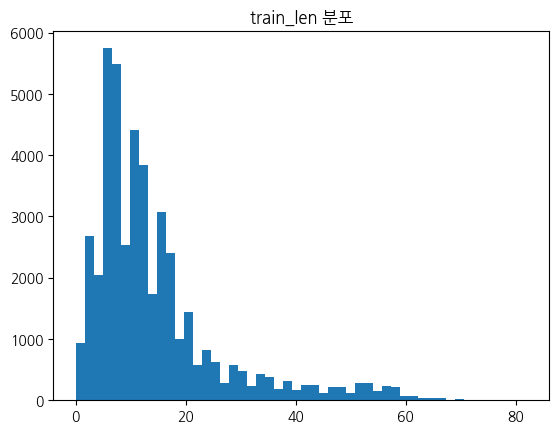

In [55]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

train_len=[]
for i in train_ids:
    train_len.append(len(i))

plt.hist(train_len, bins=50)
plt.title("train_len 분포")
plt.plot()

[]

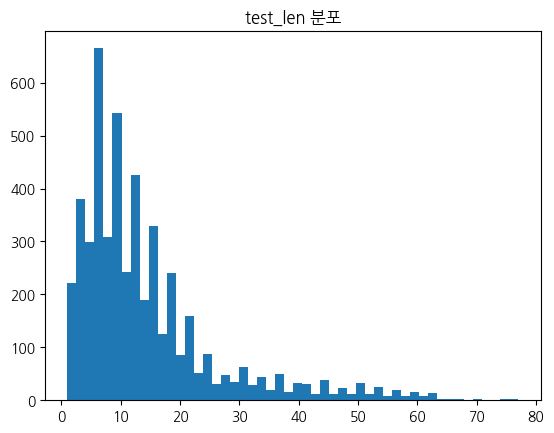

In [56]:

test_len=[]
for i in test_ids:
    test_len.append(len(i))

plt.hist(test_len, bins=50)
plt.title("test_len 분포")
plt.plot()

In [57]:
max_length = 32
pad_id = token_to_id["<pad>"]

train_ids = pad_sequences(train_ids, max_length, pad_id, start="R")
test_ids = pad_sequences(test_ids, max_length, pad_id, start="R")

print(train_ids[0])
print(test_ids[0])

[   1 1136    1 3132 1444   55  390    1    1 1642    1    1    1    1
 3852    1    1    1    1    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[2483    1 1368    1    1    1  565 3013    1    1    1    1    1    7
    1    1 3715    1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [58]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋, 데이터 로더 생성 
train_ids = torch.tensor(train_ids) # 인코딩된 데이터를 텐서로 변환
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32) # 라벨값 데이터를 텐서로 변환 
test_labels = torch.tensor(test.label.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [59]:
from torch import optim


n_vocab = len(token_to_id) # 총 단어 갯수 : 5002개 
hidden_dim = 64 
embedding_dim = 128
n_layers = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier( # 맨 처음에 만들었던, 클래스 인스턴스 생성 
    n_vocab=n_vocab, 
    hidden_dim=hidden_dim, 
    embedding_dim=embedding_dim, 
    n_layers=n_layers
).to(device)

criterion = nn.BCEWithLogitsLoss().to(device) # 이진분류에 걸맞는 BCEWithLogitsLoss()로 손실함수 설정
optimizer = optim.AdamW(classifier.parameters(), lr=0.001)  # 학습률이 빠른 AdamW로 옵티마이저 설정 

In [60]:
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets): 
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")


def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")


epochs = 5
interval = 500

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6949805021286011
Train Loss 500 : 0.694235368403132
Train Loss 1000 : 0.6933309756197058
Train Loss 1500 : 0.6811958082432273
Train Loss 2000 : 0.6567143085805969
Train Loss 2500 : 0.6364922129728946
Val Loss : 0.4963441309266197, Val Accuracy : 0.7542
Train Loss 0 : 0.3675802946090698
Train Loss 500 : 0.4825358949378579
Train Loss 1000 : 0.47865382916146104
Train Loss 1500 : 0.4754925906201508
Train Loss 2000 : 0.4720368596135468
Train Loss 2500 : 0.46786512126449775
Val Loss : 0.4466784267475049, Val Accuracy : 0.778
Train Loss 0 : 0.6229029297828674
Train Loss 500 : 0.41288287484062886
Train Loss 1000 : 0.4108634579342443
Train Loss 1500 : 0.41291356329954443
Train Loss 2000 : 0.41319307979421577
Train Loss 2500 : 0.41281556173032974
Val Loss : 0.4414752918405655, Val Accuracy : 0.7806
Train Loss 0 : 0.2602046728134155
Train Loss 500 : 0.359292420619976
Train Loss 1000 : 0.3684636000153068
Train Loss 1500 : 0.3705249474465172
Train Loss 2000 : 0.3736402564968305
Tra

In [61]:
token_to_embedding = dict()
embedding_matrix = classifier.embedding.weight.detach().cpu().numpy()

for word, emb in zip(vocab, embedding_matrix):
    token_to_embedding[word] = emb

token = vocab[1000] # 특정 단어를 갖고옴 
print(token, token_to_embedding[token])

그걸 [ 0.43552998  1.4229215  -1.6852924   0.5155019  -0.05876175  0.51151663
  1.4164498   0.41891292 -0.08484944  0.8717505  -0.12717232  1.4572483
 -0.8835179  -1.2947593   0.5007012   1.7626926   0.13984197 -1.0996906
  0.44001126  1.329247    1.4889665  -1.7276891  -0.80817056  0.6485157
  0.22799537 -0.05622512  1.2707144   1.096192   -0.39640293  0.50538975
  0.45463958  0.76028997  0.7810135   1.1038017  -1.2611519  -0.29863858
 -0.37108147 -0.57815707 -0.60276866  0.13900699  0.2965498   1.1368778
 -1.1015035   0.85699415  0.16304137 -0.4308938  -0.4335563   0.49657187
  1.3998777   0.45722497  0.674123   -1.6700646  -0.5938373  -1.5707697
 -0.62274575  0.8953141   0.1310051  -0.94871867  0.44920987  1.3852931
  0.47923502 -0.11259961  0.33066845  0.6772478  -0.20178074 -0.45546636
 -0.76551723  1.179208    1.0098587  -0.07192725 -1.3664426  -1.1778498
  1.4440747  -0.16399644  0.22075766  0.5821654   0.48305854  0.29553893
  0.9545603  -0.12615527 -1.369081    0.24893567 -0.445